In [1]:
from pathlib import Path
from datetime import datetime
import random
import torch
from torch import nn
import torch.nn.functional as F
from stable_diffusion_sds import StableDiffusion
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import reduce
from PIL import Image
import numpy as np

/home/pwhiddy/mambaforge-pypy3/envs/py10/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [2]:
#!pip install kornia
import kornia


In [3]:
device = "cuda"#"cpu"

In [4]:
def show(t):
    plt.imshow(t.permute(1,2,0).cpu().numpy())

In [5]:
sd_sds = StableDiffusion(device)

[INFO] loading stable diffusion...
[INFO] loaded stable diffusion!


In [6]:
# μNCA 
# from https://github.com/google-research/self-organising-systems/blob/master/notebooks/%CE%BCNCA_pytorch.ipynb

side = torch.tensor([[0.0, 0.0,0.0], [2.0,-2.0,0.0], [0.0, 0.0,0.0]]) 
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]) 
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

# filters = [lap]*2+[sobel_x]*1+[sobel_x.T]*1  # 68 params
# filters = [lap]*2+[sobel_x]*2+[sobel_x.T]*2 # 150 params
# filters = [lap]*4+[sobel_x]*2+[sobel_x.T]*2  # 264 params
filters = [lap]*4+[sobel_x]*4+[sobel_x.T]*4  # 588 params

filters = torch.stack(filters)[:,None]
filters = filters.to(device)
CHN = len(filters)

class CA(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(CHN, 4*CHN+1, 1, 1)*1e-3)

    def to_rgb(self, x):
        return x[...,:3,:,:]+0.5

    def forward(self, x, update_rate=1.0):
        y = torch.nn.functional.pad(x, [1, 1, 1, 1], 'circular')
        y = torch.nn.functional.conv2d(y, filters, groups=y.shape[1])
        y = torch.cat([x, y], 1)
        y = y = torch.cat([y, y.abs()], 1)
        #y = torch.cat([y.relu(), -(-y).relu()], 1)
        w, b = self.w[:,:-1], self.w[:,-1,0,0]
        y = torch.nn.functional.conv2d(y, w, b)
        if update_rate<1.0:
            y *= (torch.rand(*y.shape)+update_rate).floor()
        #return x+y, y
        return y
    
def seed_f(n, sz=128):
    return torch.rand(n, CHN, sz, sz)-0.5

ca = CA().to(device)
print('param count:', sum(p.numel() for p in ca.parameters()))

param count: 588


In [7]:
# regular nca, implementation from: https://github.com/PWhiddy/Growing-Neural-Cellular-Automata-Pytorch/blob/master/CA_Particles_V3/ca_particles/ca_model.py
# from 
class CAModel(nn.Module):
    
    def __init__(self, env_d, hidden_d, device):
        super(CAModel, self).__init__()
        self.env_d = env_d
        self.conv1 = nn.Conv2d(env_d*3, hidden_d, 1).to(device)
        self.conv2 = nn.Conv2d(hidden_d, env_d, 1).to(device)
        nn.init.zeros_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        return self.conv2(x)

    def to_rgb(self, x):
        return x[...,:3,:,:]+0.5

In [8]:
def np2pil(a):
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1)*255)
    return Image.fromarray(a)

In [9]:
#print(torch.cuda.memory_summary())

100%|█████████████████████████████████████████████████████████████████████████| 950/950 [02:15<00:00,  7.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


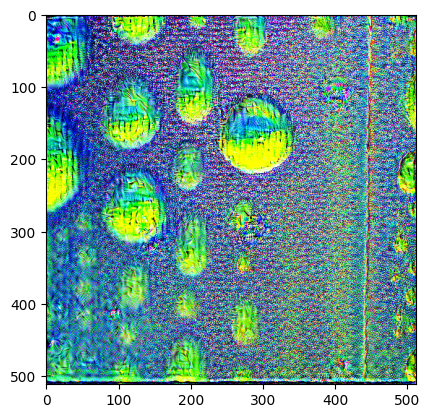

In [36]:
# dummy img training (random t)
init_img = torch.rand(1,3,512,512, device=device, requires_grad=True)
init_img.mean()
text_embeds = sd_sds.get_text_embeds(["raindrops on glass"]*batch_size, [""]*batch_size) 
opt_t = torch.optim.SGD([init_img], 0.2) #torch.optim.Adam([init_img], 0.1)
for i in tqdm(range(950)):
    # timestep ~ U(0.02, 0.98) to avoid very high/low noise level
    override_t = None#torch.tensor([975-i], dtype=torch.long, device=device)
    loss, grad_mag = sd_sds.train_step(text_embeds, init_img, guidance_scale=50, override_t=override_t)
    loss = loss
    loss.backward()
    opt_t.step()
    opt_t.zero_grad()
result = init_img[0].detach()
show(result)

In [9]:
# todo
# 1. increase model capacity
# 2. use pool to reinit from for long term stability
# 3. use simple ca model?
# 4. make memory usage less?
# 5. increase resolution

torch.manual_seed(120)
ca =  CA().to(device) #  CAModel().to(device)
batch_size = 1
batch_boost = 16
# gorgeous rainforrest brush |  water ripples from above | "red hot lava" | ripples moving out from a drop of water in clear blue, viewed from above
text_embeds = sd_sds.get_text_embeds(["raindrops on glass"]*batch_size, [""]*batch_size) 
opt = torch.optim.Adam(ca.parameters(), 1e-3)
ca_steps = 100
sds_loss_interval = 20
iterations = 5000
grad_detatch_interval = 100
norm_loss_scale = 1
sd_loss_scale = 0.0001
run_dir = Path("output/{:%Y_%m_%d_%H_%M_%S}".format(datetime.now()))
run_dir.mkdir(exist_ok=True, parents=True)
#res = torch.zeros(3, 32*5,32*5)

for i in tqdm(range(iterations)):
    
    track_grad_mag = 0
    track_norm_loss = 0
    loss_steps = 0
    for b in range(batch_boost):
        state = torch.rand(batch_size, 12, 128, 128, device=device)-0.5
        
        for step in range(ca_steps):
            state = state + ca(state)
            if step > 0 and step % sds_loss_interval == 0:
                sd_loss, grad_mag = sd_sds.train_step(text_embeds, ca.to_rgb(state), guidance_scale=200, override_t=None)
                sd_loss = sd_loss_scale * sd_loss
                # similar to MSE loss for going outside of range
                # https://www.desmos.com/calculator/74bzpyt0ho
                cur_img = ca.to_rgb(state)
                above = F.relu( cur_img - 1 ) ** 2
                below = F.relu( -cur_img ) ** 2
                total_norm_loss = norm_loss_scale * (above.mean() + below.mean())
                
                track_norm_loss += total_norm_loss.item()
                track_grad_mag += sd_loss_scale * grad_mag.item()
                loss_steps += 1
                if step == sds_loss_interval:
                    # first time only
                    loss = sd_loss
                    loss += total_norm_loss
                else:
                    loss += sd_loss
                    loss += total_norm_loss
        
        loss.backward()
    print(f"i{i} step{step} grad_mag: {track_grad_mag / loss_steps} total norm loss: {track_norm_loss / loss_steps}")
    opt.step()
    opt.zero_grad()
    
    if i % 10 == 0:
        #small = reduce(result, "c (h a) (w b) -> c h w", "mean", a=16, b=16)
        out_dir = run_dir / "states" 
        out_dir.mkdir(exist_ok=True, parents=True)
        path = out_dir / f"state-{i:06d}.jpg"
        np2pil(ca.to_rgb(state)[0].detach().permute(1,2,0).cpu().numpy()).save(path)


  0%|                                                                                  | 0/5000 [00:03<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:56                                                                                   │
│                                                                                                  │
│   53 │   │   │   │   │   loss += sd_loss                                                         │
│   54 │   │   │   │   │   loss += total_norm_loss                                                 │
│   55 │   │                                                                                       │
│ ❱ 56 │   │   loss.backward()                                                                     │
│   57 │   print(f"i{i} step{step} grad_mag: {track_grad_mag / loss_steps} total norm loss: {tr    │
│   58 │   opt.step()                                                                              │
│   59 │   opt.zero_grad()                                                                         │
│                                                                                                  │
│ /home/pwhiddy/mambaforge-pypy3/envs/py10/lib/python3.10/site-packages/torch/_tensor.py:487 in    │
│ backward                                                                                         │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    489 │   │   )                                                                                 │
│    490                                                                                           │
│                                                                                                  │
│ /home/pwhiddy/mambaforge-pypy3/envs/py10/lib/python3.10/site-packages/torch/autograd/__init__.py │
│ :204 in backward                                                                                 │
│                                                                                                  │
│   201 │   # The reason we repeat same the comment below is that                                  │
│   202 │   # some Python versions print out the first line of a multi-line function               │
│   203 │   # calls in the traceback and some print out the last line                              │
│ ❱ 204 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   205 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│   206 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   207                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

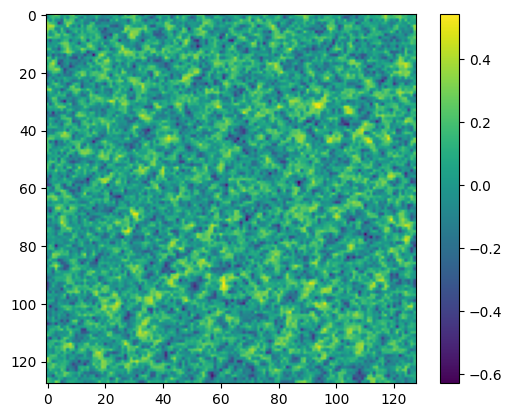

In [23]:
plt.imshow(state[0, 2].detach().cpu().numpy()+0.5)
plt.colorbar()

In [31]:
state[0, 2].detach().mean()

tensor(-0.4617, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


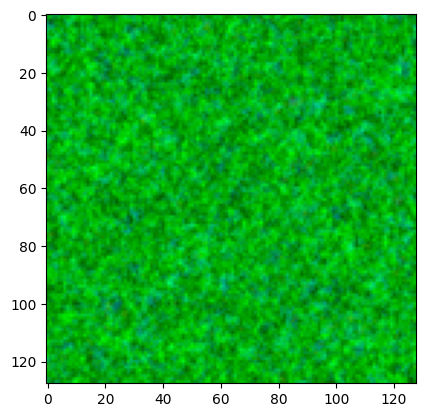

In [24]:
show(ca.to_rgb(state)[0].detach())

In [38]:
# todo
# 1. increase model capacity
# 2. use pool to reinit from for long term stability
# 3. use simple ca model?
# 4. make memory usage less?
# 5. increase resolution

def make_state(batch, channels, x, y):
    return {"state": torch.rand(batch_size, channels, x, y, device=device)-0.5, "steps": 0}

def norm_loss(cur_img, scale):
    above = F.relu( cur_img - 1 ) ** 2
    below = F.relu( -cur_img ) ** 2
    return scale * (above.mean() + below.mean())

torch.manual_seed(120)
#ca =  CA().to(device) #  CAModel().to(device)
batch_size = 1
#batch_boost = 16
pool_size = 32
reset_prob = 0.2
m_state = lambda : make_state(batch_size, 12, 128, 128)
pool = [m_state() for _ in range(pool_size)]
# gorgeous rainforrest brush |  water ripples from above | "red hot lava" | ripples moving out from a drop of water in clear blue, viewed from above
text_embeds = sd_sds.get_text_embeds(["raindrops on glass"]*batch_size, [""]*batch_size) 
opt = torch.optim.Adam(ca.parameters(), 1e-3)
ca_steps = 60
sds_loss_interval = 20
iterations = 5000
#grad_detatch_interval = 100
norm_loss_scale = 1
sd_loss_scale = 0#0.000001
run_dir = Path("output/{:%Y_%m_%d_%H_%M_%S}".format(datetime.now()))
run_dir.mkdir(exist_ok=True, parents=True)
#res = torch.zeros(3, 32*5,32*5)
for i in tqdm(range(iterations)):
    
    track_grad_mag = 0
    track_norm_loss = 0
    loss_steps = 0
    for p in range(pool_size):
        if random.uniform(0, 1) < reset_prob:
            pool[p] = m_state()
        else:
            pool[p]["state"] = pool[p]["state"].detach()
            pool[p]["steps"] += ca_steps
        state = pool[p]["state"]
        
        for step in range(ca_steps):
            state = state + ca(state)
            if step > 0 and step % sds_loss_interval == 0:
                #sd_loss, grad_mag = sd_sds.train_step(text_embeds, ca.to_rgb(state), guidance_scale=200, override_t=None)
                #sd_loss = sd_loss_scale * sd_loss
                
                # similar to MSE loss for going outside of range
                # https://www.desmos.com/calculator/74bzpyt0ho
                cur_img = ca.to_rgb(state)
                total_norm_loss = norm_loss(cur_img, norm_loss_scale)
                if total_norm_loss.item() > 100:
                    print(f"total_norm_loss: {total_norm_loss.item()}")
                
                track_norm_loss += total_norm_loss.item()
                track_grad_mag += 0#sd_loss_scale * grad_mag.item()
                loss_steps += 1
                if step == sds_loss_interval:
                    # first time only
                    loss = total_norm_loss
                    #loss = sd_loss
                    #loss += total_norm_loss
                else:
                    #loss += sd_loss
                    loss += total_norm_loss
        
        loss.backward()
    print(f"i{i} step{step} grad_mag: {track_grad_mag / loss_steps} total norm loss: {track_norm_loss / loss_steps} oldest state: {max([s['steps'] for s in pool])}")
    opt.step()
    opt.zero_grad()
    
    if i % 10 == 0:
        #small = reduce(result, "c (h a) (w b) -> c h w", "mean", a=16, b=16)
        out_dir = run_dir / "states" 
        out_dir.mkdir(exist_ok=True, parents=True)
        path = out_dir / f"state-{i:06d}.jpg"
        np2pil(ca.to_rgb(pool[0]["state"])[0].detach().permute(1,2,0).cpu().numpy()).save(path)


  0%|                                                                          | 1/5000 [00:00<35:35,  2.34it/s]

i0 step59 grad_mag: 0.0 total norm loss: 7.503445551541475e-08 oldest state: 60


  0%|                                                                          | 2/5000 [00:00<35:13,  2.36it/s]

i1 step59 grad_mag: 0.0 total norm loss: 0.25276269636378856 oldest state: 120


  0%|                                                                          | 3/5000 [00:01<35:00,  2.38it/s]

i2 step59 grad_mag: 0.0 total norm loss: 8.842484583836282e-12 oldest state: 180


  0%|                                                                          | 4/5000 [00:01<34:47,  2.39it/s]

i3 step59 grad_mag: 0.0 total norm loss: 4.852554894974048e-05 oldest state: 240


  0%|                                                                          | 5/5000 [00:02<34:28,  2.41it/s]

i4 step59 grad_mag: 0.0 total norm loss: 0.007164153189933131 oldest state: 300


  0%|                                                                          | 6/5000 [00:02<34:19,  2.42it/s]

i5 step59 grad_mag: 0.0 total norm loss: 0.027325226107677736 oldest state: 360


  0%|                                                                          | 7/5000 [00:02<34:14,  2.43it/s]

i6 step59 grad_mag: 0.0 total norm loss: 0.027289832063615904 oldest state: 420


  0%|                                                                          | 8/5000 [00:03<34:19,  2.42it/s]

i7 step59 grad_mag: 0.0 total norm loss: 0.016654232978908112 oldest state: 480


  0%|▏                                                                         | 9/5000 [00:03<34:38,  2.40it/s]

i8 step59 grad_mag: 0.0 total norm loss: 0.005557508513220455 oldest state: 540


  0%|▏                                                                        | 10/5000 [00:04<34:38,  2.40it/s]

i9 step59 grad_mag: 0.0 total norm loss: 0.00042244877550956517 oldest state: 600


  0%|▏                                                                        | 11/5000 [00:04<34:55,  2.38it/s]

i10 step59 grad_mag: 0.0 total norm loss: 4.293623534934454e-06 oldest state: 660


  0%|▏                                                                        | 12/5000 [00:05<34:52,  2.38it/s]

i11 step59 grad_mag: 0.0 total norm loss: 1.2509928364690202e-06 oldest state: 720


  0%|▏                                                                        | 13/5000 [00:05<34:38,  2.40it/s]

i12 step59 grad_mag: 0.0 total norm loss: 8.231855354312589e-07 oldest state: 780


  0%|▏                                                                        | 14/5000 [00:05<34:23,  2.42it/s]

i13 step59 grad_mag: 0.0 total norm loss: 6.119177192454028e-07 oldest state: 840


  0%|▏                                                                        | 15/5000 [00:06<34:06,  2.44it/s]

i14 step59 grad_mag: 0.0 total norm loss: 5.396640506694084e-07 oldest state: 900


  0%|▏                                                                        | 16/5000 [00:06<34:08,  2.43it/s]

i15 step59 grad_mag: 0.0 total norm loss: 5.383554566584792e-07 oldest state: 960


  0%|▏                                                                        | 17/5000 [00:07<34:17,  2.42it/s]

i16 step59 grad_mag: 0.0 total norm loss: 5.815572425085791e-07 oldest state: 1020


  0%|▎                                                                        | 18/5000 [00:07<34:03,  2.44it/s]

i17 step59 grad_mag: 0.0 total norm loss: 6.8567219426718395e-06 oldest state: 1080


  0%|▎                                                                        | 19/5000 [00:07<34:01,  2.44it/s]

i18 step59 grad_mag: 0.0 total norm loss: 0.0001032162752712118 oldest state: 1140


  0%|▎                                                                        | 20/5000 [00:08<33:56,  2.45it/s]

i19 step59 grad_mag: 0.0 total norm loss: 0.0004974452104775651 oldest state: 1200


  0%|▎                                                                        | 21/5000 [00:08<33:49,  2.45it/s]

i20 step59 grad_mag: 0.0 total norm loss: 0.0008989130160115266 oldest state: 1260


  0%|▎                                                                        | 22/5000 [00:09<33:52,  2.45it/s]

i21 step59 grad_mag: 0.0 total norm loss: 0.0006709787708722992 oldest state: 1320


  0%|▎                                                                        | 23/5000 [00:09<33:51,  2.45it/s]

i22 step59 grad_mag: 0.0 total norm loss: 0.00023432039519022396 oldest state: 1380


  0%|▎                                                                        | 24/5000 [00:09<33:40,  2.46it/s]

i23 step59 grad_mag: 0.0 total norm loss: 4.347699906093183e-05 oldest state: 1440


  0%|▎                                                                        | 25/5000 [00:10<33:47,  2.45it/s]

i24 step59 grad_mag: 0.0 total norm loss: 5.2228136169230055e-06 oldest state: 1500


  1%|▍                                                                        | 26/5000 [00:10<34:02,  2.44it/s]

i25 step59 grad_mag: 0.0 total norm loss: 2.088607472916504e-06 oldest state: 1560


  1%|▍                                                                        | 27/5000 [00:11<34:09,  2.43it/s]

i26 step59 grad_mag: 0.0 total norm loss: 6.902443368317357e-06 oldest state: 1620


  1%|▍                                                                        | 28/5000 [00:11<33:58,  2.44it/s]

i27 step59 grad_mag: 0.0 total norm loss: 2.0832297650930087e-05 oldest state: 1680


  1%|▍                                                                        | 29/5000 [00:11<34:08,  2.43it/s]

i28 step59 grad_mag: 0.0 total norm loss: 4.744907404830023e-05 oldest state: 1740


  1%|▍                                                                        | 30/5000 [00:12<34:12,  2.42it/s]

i29 step59 grad_mag: 0.0 total norm loss: 8.151547227774891e-05 oldest state: 1020


  1%|▍                                                                        | 31/5000 [00:12<34:12,  2.42it/s]

i30 step59 grad_mag: 0.0 total norm loss: 0.00010143393802386491 oldest state: 1080


  1%|▍                                                                        | 32/5000 [00:13<34:40,  2.39it/s]

i31 step59 grad_mag: 0.0 total norm loss: 9.014114567740261e-05 oldest state: 960


  1%|▍                                                                        | 33/5000 [00:13<34:23,  2.41it/s]

i32 step59 grad_mag: 0.0 total norm loss: 6.124792213241248e-05 oldest state: 1020


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:74                                                                                   │
│                                                                                                  │
│   71 │   │   │   │   │   #loss += sd_loss                                                        │
│   72 │   │   │   │   │   loss += total_norm_loss                                                 │
│   73 │   │                                                                                       │
│ ❱ 74 │   │   loss.backward()                                                                     │
│   75 │   print(f"i{i} step{step} grad_mag: {track_grad_mag / loss_steps} total norm loss: {tr    │
│   76 │   opt.step()                                                                              │
│   77 │   opt.zero_grad()                                                                         │
│                                                                                                  │
│ /home/pwhiddy/mambaforge-pypy3/envs/py10/lib/python3.10/site-packages/torch/_tensor.py:487 in    │
│ backward                                                                                         │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    489 │   │   )                                                                                 │
│    490                                                                                           │
│                                                                                                  │
│ /home/pwhiddy/mambaforge-pypy3/envs/py10/lib/python3.10/site-packages/torch/autograd/__init__.py │
│ :204 in backward                                                                                 │
│                                                                                                  │
│   201 │   # The reason we repeat same the comment below is that                                  │
│   202 │   # some Python versions print out the first line of a multi-line function               │
│   203 │   # calls in the traceback and some print out the last line                              │
│ ❱ 204 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   205 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│   206 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   207                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


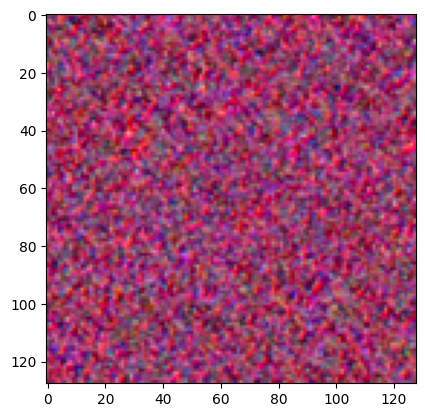

In [34]:
show(ca.to_rgb(state)[0].detach())

In [53]:
del ca, state, loss, opt, new_loss

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 del ca, state, loss, opt, new_loss                                                           │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'new_loss' is not defined

In [37]:
del sd_sds

NameError: name 'sd_sds' is not defined

In [12]:
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            if torch.numel(obj) > 1024*1024*32: 
                print(type(obj), obj.size())
                #print(obj)
            
    except:
        pass

<class 'torch.nn.parameter.Parameter'> torch.Size([49408, 1024])
<class 'torch.Tensor'> torch.Size([256, 12, 128, 128])
<class 'torch.Tensor'> torch.Size([1, 128, 513, 513])
<class 'torch.Tensor'> torch.Size([1, 128, 513, 513])
<class 'torch.Tensor'> torch.Size([1, 128, 513, 513])


/home/pwhiddy/mambaforge-pypy3/envs/py10/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:283: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [22]:
torch.cuda.empty_cache()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 torch.cuda.empty_cache()                                                                     │
│   2                                                                                              │
│                                                                                                  │
│ /home/pwhiddy/mambaforge-pypy3/envs/py10/lib/python3.10/site-packages/torch/cuda/memory.py:133   │
│ in empty_cache                                                                                   │
│                                                                                                  │
│   130 │   │   more details about GPU memory management.                                          │
│   131 │   """                                                                                    │
│   132 │   if is_initialized():                                                                   │
│ ❱ 133 │   │   torch._C._cuda_emptyCache()                                                        │
│   134                                                                                            │
│   135                                                                                            │
│   136 def memory_stats(device: Union[Device, int] = None) -> Dict[str, Any]:                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be 
incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

In [21]:
torch.cuda.memory_allocated()

18846907392

In [28]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from tqdm import tqdm_notebook, tnrange

In [35]:
def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

class LoopWriter(VideoWriter):
  def __init__(self, *a, fade_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.fade_len = int(fade_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.fade_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.fade_len:
      super().add(self._outro.pop(0))
  
  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

In [36]:
step_n = 1
with torch.no_grad():
    with LoopWriter('final_ca.mp4', fade_len=0.5) as vid, torch.no_grad():
        x = m_state()["state"]
        #x[:] = 0.0
        #x[:,:,100, 100] = 1.0
        for k in tnrange(800, leave=False):
            img = ca.to_rgb(x)[0].detach().permute(1,2,0).cpu().numpy()
            #print(img.mean())
            vid.add(zoom(img, 2))
            #step_n = int(min(2**(k/30), 8))
            for i in range(step_n):
                x = x + ca(x)
    vid.show()

  0%|          | 0/800 [00:00<?, ?it/s]

In [37]:
img.mean()

-13659268.0

In [25]:
norm_loss(x, 1)

tensor(3.4056e+16, device='cuda:0')

In [43]:
del ca, state, loss, opt

NameError: name 'ca' is not defined

In [40]:
x = torch.randn(1,12,128,128, device=device)
for i in range(100):
    x = x + ca(x)